<a href="https://colab.research.google.com/github/Ghadiiz/movie-sentiment-analyzer-nlp/blob/main/Movie_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
def setup_nlp_environment():
    """Imports common NLP libraries and downloads NLTK data packages."""
    print("Importing necessary libraries...")
    try:
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        import nltk
        from sklearn.model_selection import train_test_split
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.naive_bayes import MultinomialNB
        from sklearn.metrics import classification_report, accuracy_score
        try:
            import tensorflow as tf
            from tensorflow import keras
        except ImportError:
            print("TensorFlow/Keras not found. Skipping import.")

        print("Libraries imported successfully.")

        print("Downloading NLTK data packages...")
        nltk.download('stopwords', quiet=True)
        nltk.download('punkt', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True) # Open Multilingual WordNet, often needed with wordnet
        nltk.download('punkt_tab', quiet=True) # Added to resolve LookupError
        print("NLTK data packages downloaded successfully.")

        # Optional: Set up plotting style
        sns.set_style("whitegrid")
        plt.rcParams['figure.figsize'] = [10, 6]

    except ImportError as e:
        print(f"Error importing a library: {e}. Please ensure all libraries are installed.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the function to set up the environment
setup_nlp_environment()

Importing necessary libraries...
Libraries imported successfully.
NLTK data packages downloaded successfully.


In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import imdb

# 1. Load the IMDB dataset
# num_words parameter keeps the most frequent words
max_features = 10000  # consider only top 10k words
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 2. Get the word index and create a reverse word index
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# The indices are offset by 3 because 0, 1, and 2 are reserved for "padding," "start of sequence," and "unknown."
# Define a decoding function
def decode_review(text_sequence):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text_sequence])

# 3. Convert integer sequences back to text reviews
train_reviews_text = [decode_review(seq) for seq in x_train]
test_reviews_text = [decode_review(seq) for seq in x_test]

# 4. Create pandas DataFrames
# Combine train and test data
reviews = train_reviews_text + test_reviews_text
sentiments = np.concatenate((y_train, y_test), axis=0)

imdb_df = pd.DataFrame({'review': reviews, 'sentiment': sentiments})

# Map sentiment labels to 'positive' and 'negative' for clarity if desired
# imdb_df['sentiment'] = imdb_df['sentiment'].map({0: 'negative', 1: 'positive'})

# 5. Display the first few rows, DataFrame shape, and data types
print("\n--- IMDB Dataset DataFrame ---")
print("First 5 rows:")
print(imdb_df.head())

print(f"\nDataFrame shape: {imdb_df.shape}")

print("\nDataFrame info:")
imdb_df.info()


--- IMDB Dataset DataFrame ---
First 5 rows:
                                              review  sentiment
0  ? this film was just brilliant casting locatio...          1
1  ? big hair big boobs bad music and a giant saf...          0
2  ? this has to be one of the worst films of the...          0
3  ? the ? ? at storytelling the traditional sort...          1
4  ? worst mistake of my life br br i picked this...          0

DataFrame shape: (50000, 2)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB



--- Exploratory Data Analysis on IMDB Dataset ---

1. Sentiment Distribution:


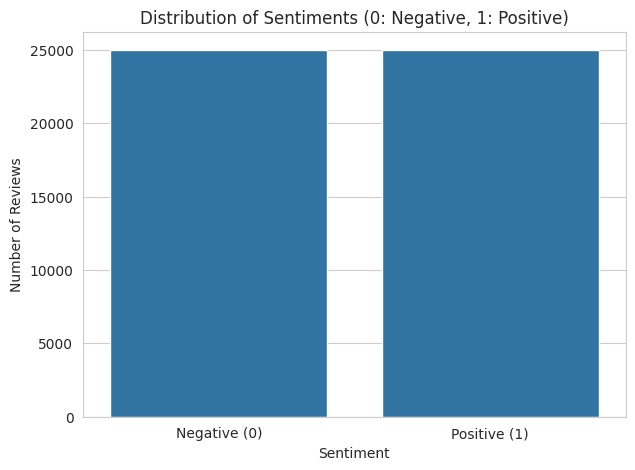


2. Review Length Distribution:


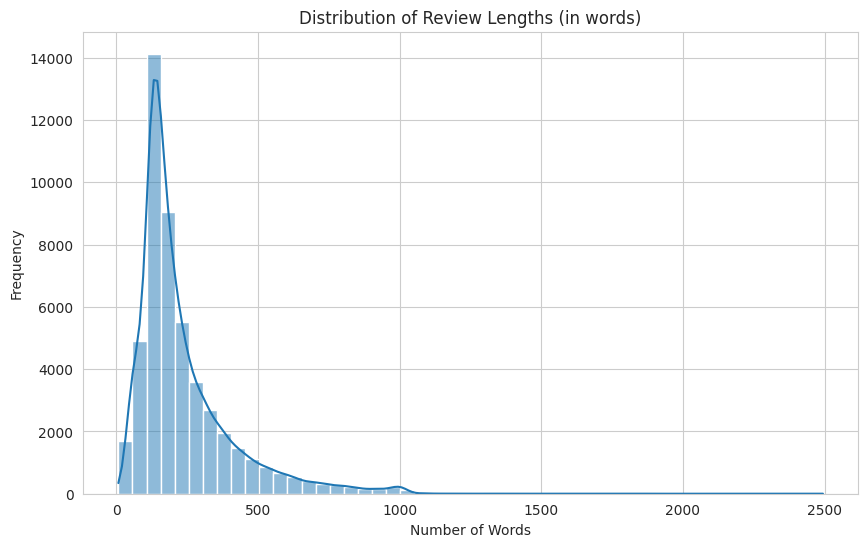


3. Missing Values Check:
review           0
sentiment        0
review_length    0
dtype: int64

4. Five Random Sample Reviews:

Sentiment: Negative
Review: ? this woman is a terrible comedian she can't crack a joke she has no real character this is another example of typical american rubbish that people laugh at because they have no idea how to react so they say to themselves well it's a comedy show so i'll laugh i guess br br i cannot stand this miserable woman and her ? poor excuse for comedy she does not deserve anything but ? br br why can't america dump this kind of delight and go for something that actually contains humour br br she is not funny not at all why oh why does even one person like this idiot

Sentiment: Positive
Review: ? so often with stephen king adaptations you just get a collection of characters ? dialogue from the books this really captures the heart of the book maybe because they don't use large ? of text straight from the book but it's a bit more of an ? of th

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n--- Exploratory Data Analysis on IMDB Dataset ---")

# 1) Bar chart showing count of positive vs negative reviews
print("\n1. Sentiment Distribution:")
plt.figure(figsize=(7, 5))
sns.countplot(x='sentiment', data=imdb_df)
plt.title('Distribution of Sentiments (0: Negative, 1: Positive)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.show()

# 2) Histogram showing distribution of review lengths in words
print("\n2. Review Length Distribution:")
# Calculate review lengths
imdb_df['review_length'] = imdb_df['review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(imdb_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# 3) Check for missing values
print("\n3. Missing Values Check:")
print(imdb_df.isnull().sum())

# 4) Display 5 random sample reviews with their sentiments
print("\n4. Five Random Sample Reviews:")
for index, row in imdb_df.sample(5).iterrows():
    print(f"\nSentiment: {'Positive' if row['sentiment'] == 1 else 'Negative'}")
    print(f"Review: {row['review']}")

# Drop the temporary 'review_length' column if no longer needed
imdb_df = imdb_df.drop(columns=['review_length'])

In [14]:
import re
# from bs4 import BeautifulSoup # Uncomment if you prefer BeautifulSoup for HTML removal and install it

def clean_text(text):
    """
    Performs text preprocessing steps:
    1. Converts to lowercase.
    2. Removes HTML tags.
    3. Removes special characters and punctuation (keeping only letters and spaces).
    4. Removes extra whitespaces.
    """
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove HTML tags (using regex for simplicity as BeautifulSoup might require installation)
    text = re.sub(r'<.*?>', '', text)
    # If using BeautifulSoup: text = BeautifulSoup(text, 'html.parser').get_text()

    # 3. Remove special characters and punctuation (keeping only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # 4. Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the clean_text function to create a new 'cleaned_review' column
print("Applying text cleaning to 'review' column...")
imdb_df['cleaned_review'] = imdb_df['review'].apply(clean_text)
print("Cleaning complete. 'cleaned_review' column created.")

# Display before and after examples of 3 random reviews
print("\n--- Before and After Cleaning Examples (3 Reviews) ---")
sample_reviews = imdb_df.sample(3)

for index, row in sample_reviews.iterrows():
    print(f"\nOriginal Review:\n{row['review']}")
    print(f"Cleaned Review:\n{row['cleaned_review']}")
    print("--------------------------------------------------")

Applying text cleaning to 'review' column...
Cleaning complete. 'cleaned_review' column created.

--- Before and After Cleaning Examples (3 Reviews) ---

Original Review:
? this late ish effort from plays as a modern day 70's that is gothic thriller but comes out short of thrills certainly it's not a dreadfully bad film it's ? got that feeling which many of later films have of someone who has given up when he's seen the first it starts out good enough almost giallo like in tone then takes a turn into gothic ? with a decent albeit terribly cliché set up then suddenly seems to have lost interest in the film and all we get is prolonged shots of ? keaton and burning ? then circa an hour into the film we get some sort of violent climax with decent to poor special effects this is followed by a slow paced with a very obvious twist ending if it's even intended to be a twist and throw a few very ? ? scenes along the way and you got tragic ceremony thus in parts it's got its qualities but then s

Applying tokenization, stopword removal, and lemmatization to 'cleaned_review' column...
Processing complete. 'processed_review' column created.

--- Before and After Processing Examples (3 Reviews) ---

Original Review (Cleaned):
i had the dubious opportunity to view this movie on tv its the perfect example of how to take a terrible script and turn it into one of the worst films ever made not only is the acting bad and the effects terrible the movie has more logical holes than ten pounds of swiss cheese br br i would highly recommend this film as an example of how not to make a movie and what director not to use in one of yours br br i turned off the tv during the last ten hideous minutes of the show calling it pathetic is a gross understatement
Processed Review:
dubious opportunity view movie tv perfect example take terrible script turn one worst film ever made acting bad effect terrible movie logical hole ten pound swiss cheese br br would highly recommend film example make movie di

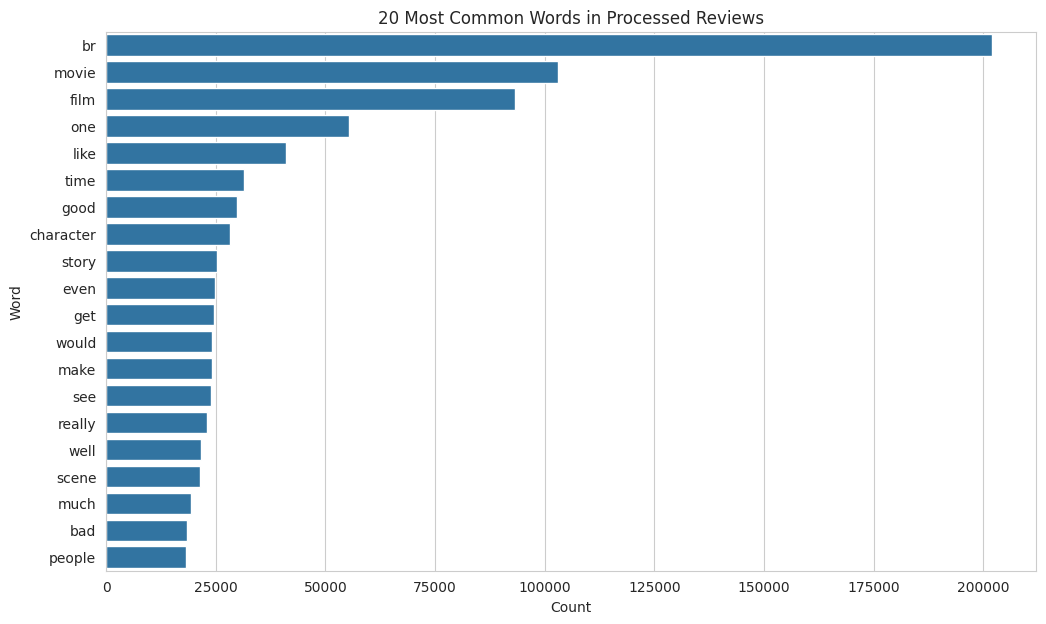

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Re-import for explicit use if not already in scope, though it is.

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    """
    Tokenizes the text, removes stopwords, and applies lemmatization.
    """
    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and lemmatize
    processed_tokens = []
    for word in tokens:
        if word not in stop_words:
            processed_tokens.append(lemmatizer.lemmatize(word))

    return ' '.join(processed_tokens)

print("Applying tokenization, stopword removal, and lemmatization to 'cleaned_review' column...")
imdb_df['processed_review'] = imdb_df['cleaned_review'].apply(process_text)
print("Processing complete. 'processed_review' column created.")

# Display before and after examples of 3 random reviews
print("\n--- Before and After Processing Examples (3 Reviews) ---")
sample_reviews_processed = imdb_df.sample(3)

for index, row in sample_reviews_processed.iterrows():
    print(f"\nOriginal Review (Cleaned):\n{row['cleaned_review']}")
    print(f"Processed Review:\n{row['processed_review']}")
    print("--------------------------------------------------")

# Display 20 most common words after processing
print("\n--- 20 Most Common Words After Processing ---")
all_words = ' '.join(imdb_df['processed_review']).split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Create a DataFrame for plotting
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

plt.figure(figsize=(12, 7))
sns.barplot(x='Count', y='Word', data=common_words_df)
plt.title('20 Most Common Words in Processed Reviews')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported

print("\n--- Data Splitting and TF-IDF Vectorization ---")

# Define features (X) and target (y)
X = imdb_df['processed_review']
y = imdb_df['sentiment']

# Split the dataset into training and testing sets (80/20 split) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dataset split into training and testing sets.")

# Initialize TfidfVectorizer
# max_features is set to 5000 as requested, considering the top 5000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data only
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform both training and testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Text data vectorized using TF-IDF.")

# Display shapes of the resulting datasets
print("\nShapes of the datasets:")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Display vocabulary size
vocabulary_size = len(tfidf_vectorizer.get_feature_names_out())
print(f"\nVocabulary size (number of features): {vocabulary_size}")

# Display a sample of the TF-IDF matrix
# Since TF-IDF matrix is sparse, we convert a small part to dense for display
print("\nSample of TF-IDF matrix (first 5 rows and first 10 columns):")
print(X_train_tfidf[:5, :10].toarray())

print("\nData preparation complete.")


--- Data Splitting and TF-IDF Vectorization ---
Dataset split into training and testing sets.
Text data vectorized using TF-IDF.

Shapes of the datasets:
X_train_tfidf shape: (40000, 5000)
X_test_tfidf shape: (10000, 5000)
y_train shape: (40000,)
y_test shape: (10000,)

Vocabulary size (number of features): 5000

Sample of TF-IDF matrix (first 5 rows and first 10 columns):
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.13318681]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]

Data preparation complete.


In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

print("\n--- Multinomial Naive Bayes Model Training and Evaluation ---")

# Initialize the Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()

# Train the classifier on the training data
print("Training Multinomial Naive Bayes classifier...")
mnb_classifier.fit(X_train_tfidf, y_train)
print("Training complete.")

# Make predictions on the training set
y_train_pred = mnb_classifier.predict(X_train_tfidf)

# Make predictions on the test set
y_test_pred = mnb_classifier.predict(X_test_tfidf)

# Calculate and display accuracy for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

# Calculate and display accuracy for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Display classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

print("\nModel evaluation complete.")


--- Multinomial Naive Bayes Model Training and Evaluation ---
Training Multinomial Naive Bayes classifier...
Training complete.

Training Accuracy: 0.8651
Test Accuracy: 0.8547

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5000
           1       0.85      0.86      0.86      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Model evaluation complete.


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("\n--- Logistic Regression Model Training and Evaluation ---")

# Initialize the Logistic Regression classifier
# max_iter is increased to ensure convergence for the given dataset
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier on the training data
print("Training Logistic Regression classifier...")
lr_classifier.fit(X_train_tfidf, y_train)
print("Training complete.")

# Make predictions on the training set
y_train_pred_lr = lr_classifier.predict(X_train_tfidf)

# Make predictions on the test set
y_test_pred_lr = lr_classifier.predict(X_test_tfidf)

# Calculate and display accuracy for training set
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
print(f"\nTraining Accuracy (Logistic Regression): {train_accuracy_lr:.4f}")

# Calculate and display accuracy for test set
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f"Test Accuracy (Logistic Regression): {test_accuracy_lr:.4f}")

# Display classification report for the test set
print("\nClassification Report for Test Set (Logistic Regression):")
print(classification_report(y_test, y_test_pred_lr))

print("\nLogistic Regression Model evaluation complete.")


--- Logistic Regression Model Training and Evaluation ---
Training Logistic Regression classifier...
Training complete.

Training Accuracy (Logistic Regression): 0.9128
Test Accuracy (Logistic Regression): 0.8869

Classification Report for Test Set (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Logistic Regression Model evaluation complete.


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print("\n--- Random Forest Classifier Training and Evaluation ---")

# Initialize the Random Forest classifier
# n_estimators is the number of trees in the forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

# Train the classifier on the training data
print("Training Random Forest classifier... (This may take a few minutes)")
rf_classifier.fit(X_train_tfidf, y_train)
print("Training complete.")

# Make predictions on the training set
y_train_pred_rf = rf_classifier.predict(X_train_tfidf)

# Make predictions on the test set
y_test_pred_rf = rf_classifier.predict(X_test_tfidf)

# Calculate and display accuracy for training set
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"\nTraining Accuracy (Random Forest): {train_accuracy_rf:.4f}")

# Calculate and display accuracy for test set
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Test Accuracy (Random Forest): {test_accuracy_rf:.4f}")

# Display classification report for the test set
print("\nClassification Report for Test Set (Random Forest):")
print(classification_report(y_test, y_test_pred_rf))

print("\nRandom Forest Classifier evaluation complete.")


--- Random Forest Classifier Training and Evaluation ---
Training Random Forest classifier... (This may take a few minutes)
Training complete.

Training Accuracy (Random Forest): 1.0000
Test Accuracy (Random Forest): 0.8451

Classification Report for Test Set (Random Forest):
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      5000
           1       0.85      0.84      0.84      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Random Forest Classifier evaluation complete.
